<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/seblock3_50epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.5 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 73.0MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf, se = True )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, se = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, se = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:45<00:00,  1.02s/it]


epoch: 0, lossD:0.8060078920561422, lossG:11.851072441027002,lossG_fake:8.208633216839392, lossG_real:3.6424392632489067 ,equality:4.566193953590485


evaluate:122.97792053222656,kid_mean:0.07894439995288849, kid_std:0.01876477710902691,kid_:(tensor(0.0789), tensor(0.0188))


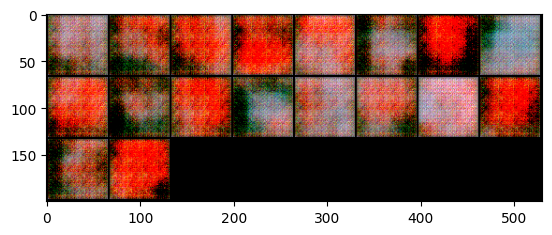

100%|██████████| 103/103 [00:09<00:00, 10.98it/s]


epoch: 1, lossD:0.7618379476254137, lossG:6.573682136906004,lossG_fake:3.7694823857650017, lossG_real:2.804199750272973 ,equality:0.9652826354920285


evaluate:123.67308044433594,kid_mean:0.08503773808479309, kid_std:0.03303486853837967,kid_:(tensor(0.0850), tensor(0.0330))


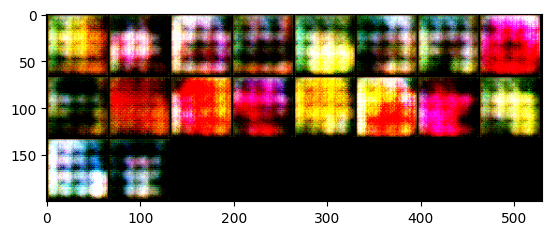

100%|██████████| 103/103 [00:09<00:00, 10.66it/s]


epoch: 2, lossD:1.0655479137469264, lossG:6.022022812111864,lossG_fake:3.632766963208763, lossG_real:2.3892558529539016 ,equality:1.2435111102548615


evaluate:122.7540283203125,kid_mean:0.08423057198524475, kid_std:0.04026983678340912,kid_:(tensor(0.0842), tensor(0.0403))


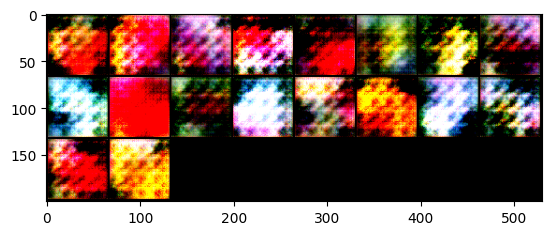

100%|██████████| 103/103 [00:09<00:00, 10.78it/s]


epoch: 3, lossD:0.999188176347214, lossG:6.098242847664842,lossG_fake:3.6321049280536983, lossG_real:2.46613790051451 ,equality:1.1659670275391885


evaluate:118.34841918945312,kid_mean:0.07645194977521896, kid_std:0.03506825864315033,kid_:(tensor(0.0765), tensor(0.0351))


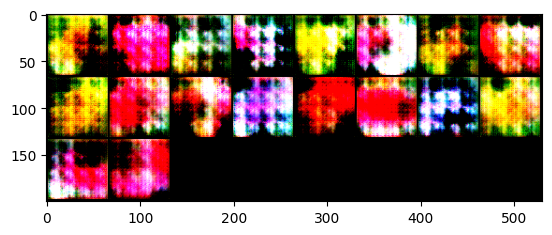

100%|██████████| 103/103 [00:09<00:00, 10.96it/s]


epoch: 4, lossD:0.8944941096514174, lossG:6.1604217094125095,lossG_fake:3.7647535060215924, lossG_real:2.3956682219088656 ,equality:1.3690852841127268


evaluate:115.45808410644531,kid_mean:0.07705941796302795, kid_std:0.03661732003092766,kid_:(tensor(0.0771), tensor(0.0366))


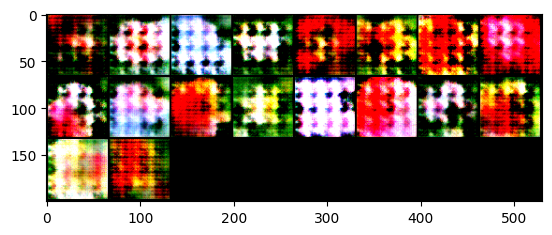

100%|██████████| 103/103 [00:09<00:00, 10.90it/s]


epoch: 5, lossD:0.9432907440129993, lossG:5.962088538605032,lossG_fake:3.562846843478749, lossG_real:2.399241691654168 ,equality:1.163605151824581


evaluate:122.76691436767578,kid_mean:0.08403194695711136, kid_std:0.0425955131649971,kid_:(tensor(0.0840), tensor(0.0426))


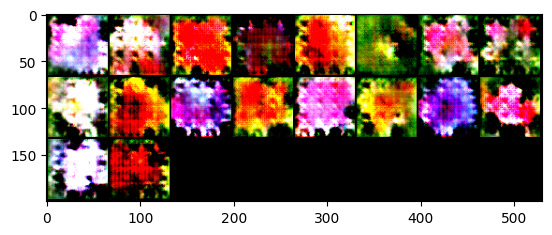

100%|██████████| 103/103 [00:09<00:00, 10.72it/s]


epoch: 6, lossD:1.0598576714112922, lossG:5.677907281708949,lossG_fake:3.401465347669657, lossG_real:2.276441937511407 ,equality:1.1250234101582501


evaluate:118.86871337890625,kid_mean:0.08685822784900665, kid_std:0.04016683250665665,kid_:(tensor(0.0869), tensor(0.0402))


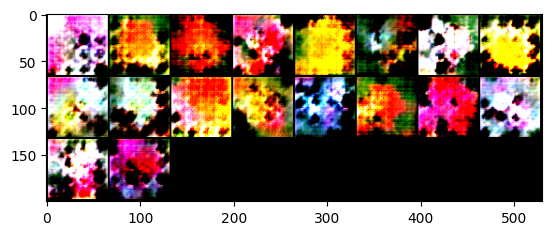

100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


epoch: 7, lossD:0.902239072380714, lossG:5.677066238181105,lossG_fake:3.3078128296194724, lossG_real:2.3692534027747736 ,equality:0.9385594268446988


evaluate:115.7156753540039,kid_mean:0.07817520946264267, kid_std:0.03732060641050339,kid_:(tensor(0.0782), tensor(0.0373))


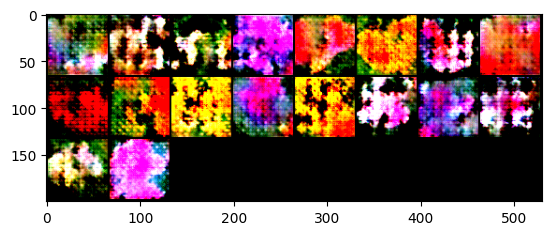

100%|██████████| 103/103 [00:09<00:00, 11.02it/s]


epoch: 8, lossD:1.0923834975483349, lossG:5.27206126463066,lossG_fake:3.056341510374569, lossG_real:2.2157197299512843 ,equality:0.8406217804232847


evaluate:117.3596420288086,kid_mean:0.07905733585357666, kid_std:0.04441501200199127,kid_:(tensor(0.0791), tensor(0.0444))


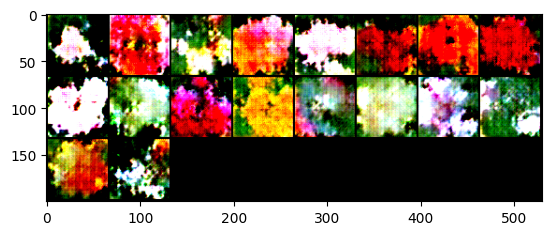

100%|██████████| 103/103 [00:09<00:00, 11.13it/s]


epoch: 9, lossD:1.2436660826206207, lossG:4.945955313525154,lossG_fake:2.81492955186992, lossG_real:2.1310257668634063 ,equality:0.6839037850065139


evaluate:121.8159408569336,kid_mean:0.08673917502164841, kid_std:0.03895050287246704,kid_:(tensor(0.0867), tensor(0.0390))


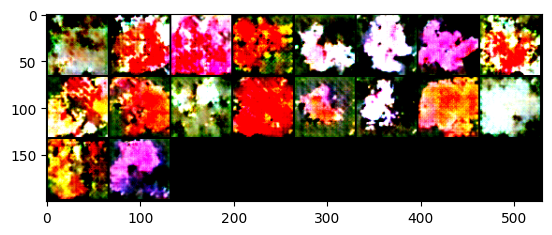

100%|██████████| 103/103 [00:09<00:00, 10.89it/s]


epoch: 10, lossD:1.1230523458962303, lossG:4.927998042801051,lossG_fake:2.7594705970541944, lossG_real:2.1685274558738596 ,equality:0.5909431411803348


evaluate:117.7806396484375,kid_mean:0.085450179874897, kid_std:0.03958924859762192,kid_:(tensor(0.0855), tensor(0.0396))


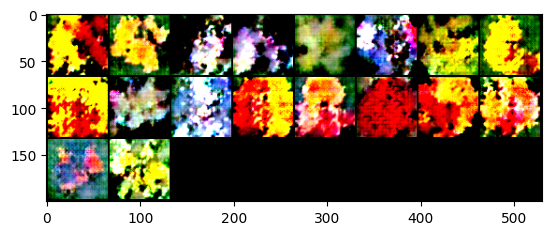

100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


epoch: 11, lossD:1.061192525243296, lossG:5.008157878246122,lossG_fake:2.795493258434592, lossG_real:2.212664597821467 ,equality:0.5828286606131248


evaluate:115.1240463256836,kid_mean:0.07843555510044098, kid_std:0.04002302512526512,kid_:(tensor(0.0784), tensor(0.0400))


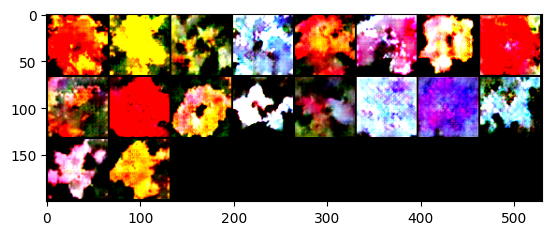

100%|██████████| 103/103 [00:09<00:00, 11.04it/s]


epoch: 12, lossD:1.0496494784517196, lossG:5.10314473365117,lossG_fake:2.8204740146988803, lossG_real:2.2826707351554947 ,equality:0.5378032795433856


evaluate:117.94935607910156,kid_mean:0.08699661493301392, kid_std:0.04488266259431839,kid_:(tensor(0.0870), tensor(0.0449))


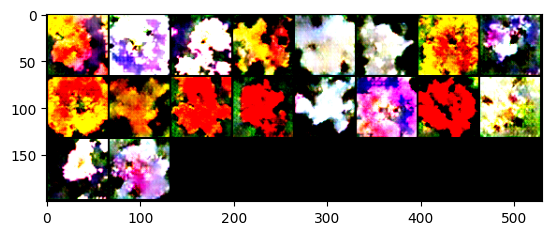

100%|██████████| 103/103 [00:09<00:00, 11.08it/s]


epoch: 13, lossD:1.0309288063384954, lossG:5.28626466954796,lossG_fake:2.957358311680914, lossG_real:2.328906353092888 ,equality:0.6284519585880259


evaluate:112.0738754272461,kid_mean:0.07941369712352753, kid_std:0.040924545377492905,kid_:(tensor(0.0794), tensor(0.0409))


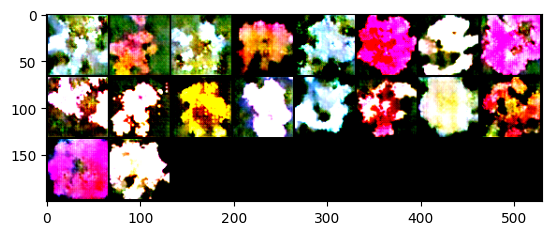

100%|██████████| 103/103 [00:09<00:00, 10.76it/s]


epoch: 14, lossD:0.9390086366713626, lossG:5.28987817856872,lossG_fake:2.888219663240377, lossG_real:2.4016585109881983 ,equality:0.4865611522521789


evaluate:110.60530090332031,kid_mean:0.07629016041755676, kid_std:0.04001682251691818,kid_:(tensor(0.0763), tensor(0.0400))


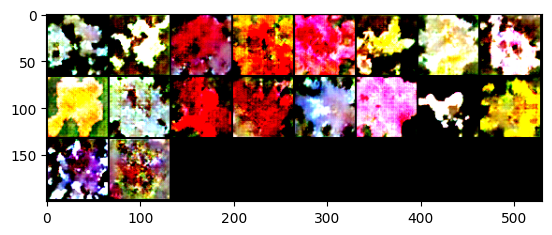

100%|██████████| 103/103 [00:09<00:00, 10.92it/s]


epoch: 15, lossD:0.9328711296169503, lossG:5.347336926506561,lossG_fake:2.957351808409089, lossG_real:2.3899851452957077 ,equality:0.5673666631133814


evaluate:108.85800170898438,kid_mean:0.07109711319208145, kid_std:0.036785274744033813,kid_:(tensor(0.0711), tensor(0.0368))


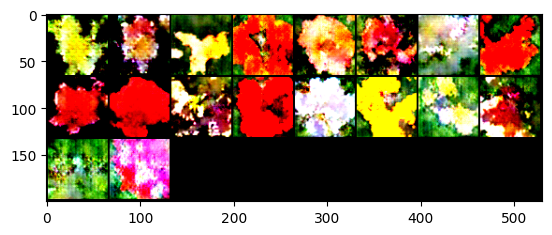

100%|██████████| 103/103 [00:09<00:00, 10.87it/s]


epoch: 16, lossD:0.8970502163599996, lossG:5.408853919760695,lossG_fake:2.9426622859482627, lossG_real:2.466191647122207 ,equality:0.47647063882605556


evaluate:113.73439025878906,kid_mean:0.06705301254987717, kid_std:0.0361519418656826,kid_:(tensor(0.0671), tensor(0.0362))


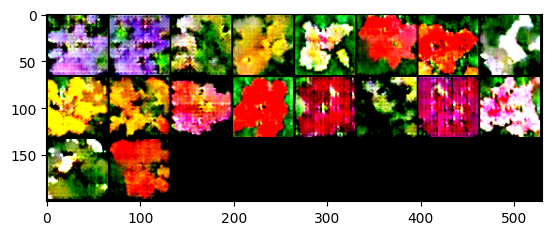

100%|██████████| 103/103 [00:09<00:00, 11.18it/s]


epoch: 17, lossD:0.8566843190239471, lossG:5.605313328863348,lossG_fake:3.076123239345921, lossG_real:2.529190061161819 ,equality:0.5469331781841018


evaluate:112.96234893798828,kid_mean:0.07751013338565826, kid_std:0.040290068835020065,kid_:(tensor(0.0775), tensor(0.0403))


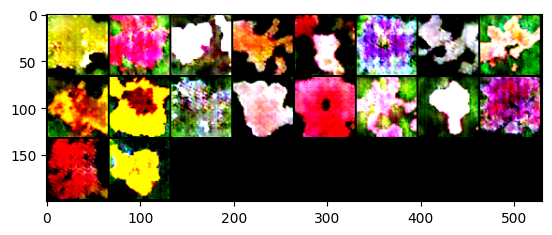

100%|██████████| 103/103 [00:09<00:00, 10.89it/s]


epoch: 18, lossD:0.8029396811735283, lossG:5.707443589145697,lossG_fake:3.0767153165872814, lossG_real:2.6307282748731593 ,equality:0.44598704171412207


evaluate:113.71265411376953,kid_mean:0.07929418236017227, kid_std:0.04141846299171448,kid_:(tensor(0.0793), tensor(0.0414))


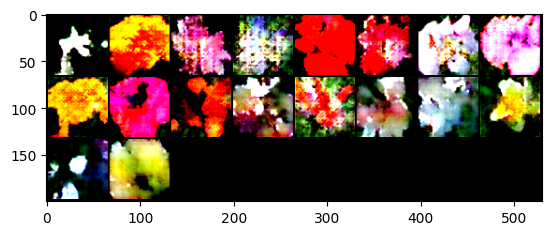

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 19, lossD:0.7423654783119276, lossG:5.740640473597258,lossG_fake:3.108782829011528, lossG_real:2.631857611021949 ,equality:0.4769252179895789


evaluate:114.17330932617188,kid_mean:0.07398008555173874, kid_std:0.04394993931055069,kid_:(tensor(0.0740), tensor(0.0439))


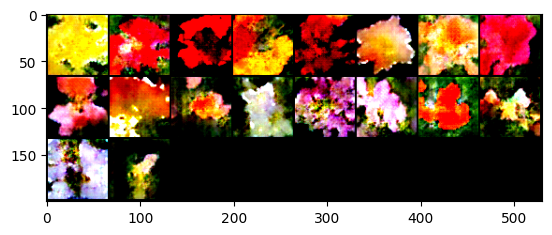

100%|██████████| 103/103 [00:09<00:00, 11.20it/s]


epoch: 20, lossD:0.6702033825291013, lossG:5.955011052992737,lossG_fake:3.2078648226932414, lossG_real:2.7471462216192077 ,equality:0.4607186010740336


evaluate:114.0545654296875,kid_mean:0.07542020082473755, kid_std:0.041423097252845764,kid_:(tensor(0.0754), tensor(0.0414))


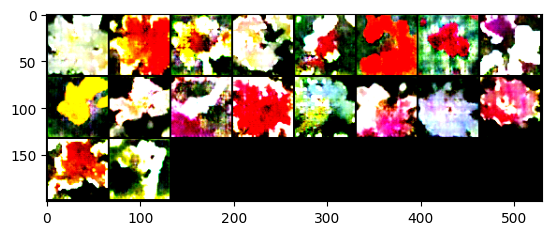

100%|██████████| 103/103 [00:09<00:00, 11.00it/s]


epoch: 21, lossD:0.667359233408877, lossG:6.069943432669038,lossG_fake:3.2199875831025317, lossG_real:2.8499558614295664 ,equality:0.3700317216729654


evaluate:115.67967224121094,kid_mean:0.08080408722162247, kid_std:0.04182291030883789,kid_:(tensor(0.0808), tensor(0.0418))


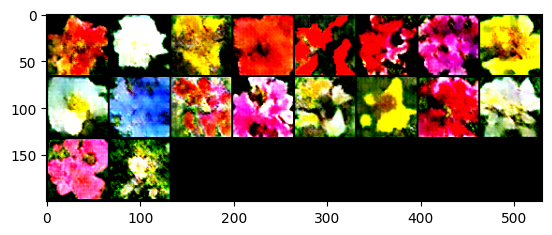

100%|██████████| 103/103 [00:09<00:00, 11.04it/s]


epoch: 22, lossD:0.5478515054271059, lossG:6.191244342952099,lossG_fake:3.359285443731882, lossG_real:2.8319589177381643 ,equality:0.5273265259937179


evaluate:115.08448791503906,kid_mean:0.07312029600143433, kid_std:0.04207228124141693,kid_:(tensor(0.0731), tensor(0.0421))


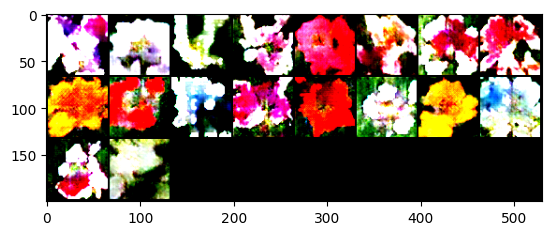

100%|██████████| 103/103 [00:09<00:00, 11.24it/s]


epoch: 23, lossD:0.5805686040266046, lossG:6.381687812434817,lossG_fake:3.4179368458905266, lossG_real:2.963750967122976 ,equality:0.45418587876755057


evaluate:114.28067016601562,kid_mean:0.07542849332094193, kid_std:0.03895121440291405,kid_:(tensor(0.0754), tensor(0.0390))


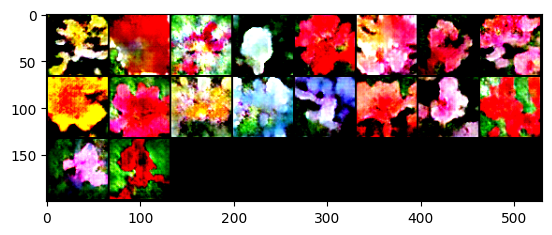

100%|██████████| 103/103 [00:09<00:00, 11.11it/s]


epoch: 24, lossD:0.5489306430359489, lossG:6.485750948341147,lossG_fake:3.5149617866405007, lossG_real:2.9707891761677936 ,equality:0.5441726104727072


evaluate:114.26815032958984,kid_mean:0.07757281512022018, kid_std:0.037321653217077255,kid_:(tensor(0.0776), tensor(0.0373))


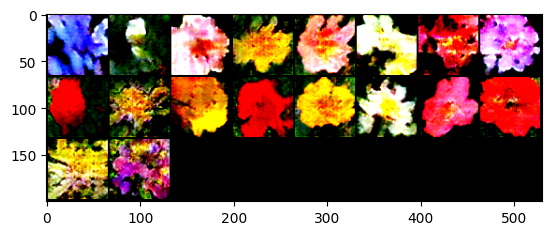

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 25, lossD:0.5299039004207815, lossG:6.5052993367019205,lossG_fake:3.482718380330836, lossG_real:3.022580965051373 ,equality:0.46013741527946284


evaluate:114.17242431640625,kid_mean:0.07515200972557068, kid_std:0.03984425216913223,kid_:(tensor(0.0752), tensor(0.0398))


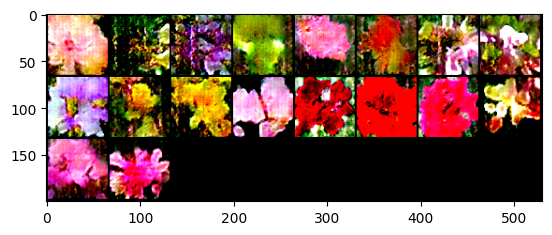

100%|██████████| 103/103 [00:09<00:00, 10.99it/s]


epoch: 26, lossD:0.476793379821245, lossG:6.617862451423719,lossG_fake:3.5202830138715724, lossG_real:3.097579438709518 ,equality:0.42270357516205426


evaluate:110.59851837158203,kid_mean:0.06475669145584106, kid_std:0.031725335866212845,kid_:(tensor(0.0648), tensor(0.0317))


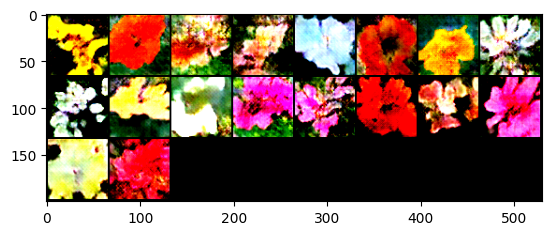

100%|██████████| 103/103 [00:09<00:00, 11.29it/s]


epoch: 27, lossD:0.5454724978619409, lossG:6.76328419250192,lossG_fake:3.625960828031151, lossG_real:3.1373233563691665 ,equality:0.48863747166198435


evaluate:109.56720733642578,kid_mean:0.07035118341445923, kid_std:0.037046078592538834,kid_:(tensor(0.0704), tensor(0.0370))


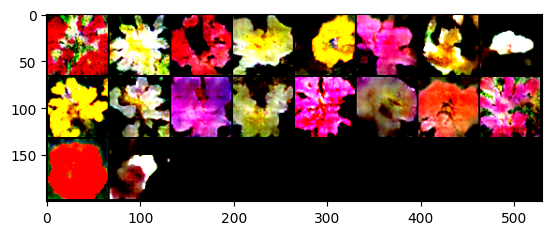

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 28, lossD:0.5246758615797006, lossG:6.760560563467081,lossG_fake:3.674747127931095, lossG_real:3.085813409495122 ,equality:0.5889337184359729


evaluate:110.40123748779297,kid_mean:0.07165912538766861, kid_std:0.041093647480010986,kid_:(tensor(0.0717), tensor(0.0411))


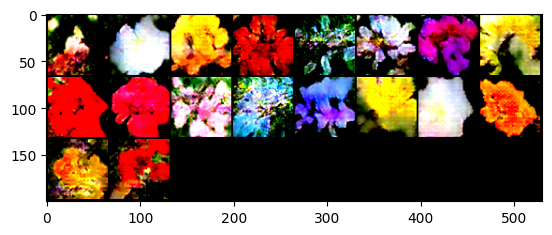

100%|██████████| 103/103 [00:09<00:00, 10.85it/s]


epoch: 29, lossD:0.4650449097084189, lossG:6.779618105842072,lossG_fake:3.634954895788026, lossG_real:3.14466320455653 ,equality:0.4902916912314961


evaluate:107.48788452148438,kid_mean:0.06516249477863312, kid_std:0.03854374215006828,kid_:(tensor(0.0652), tensor(0.0385))


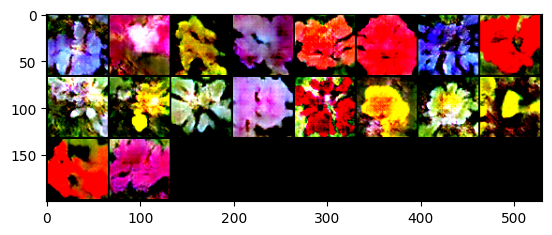

100%|██████████| 103/103 [00:09<00:00, 11.14it/s]


epoch: 30, lossD:0.47227909900609727, lossG:6.916233576617195,lossG_fake:3.786105521674295, lossG_real:3.130128042790496 ,equality:0.6559774788837989


evaluate:107.71585845947266,kid_mean:0.06942878663539886, kid_std:0.03779345378279686,kid_:(tensor(0.0694), tensor(0.0378))


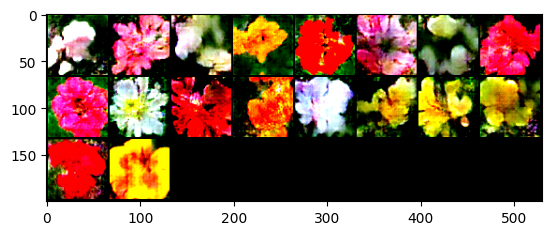

100%|██████████| 103/103 [00:09<00:00, 10.82it/s]


epoch: 31, lossD:0.5222830439655526, lossG:6.840004212647965,lossG_fake:3.6333236069355195, lossG_real:3.2066806010829594 ,equality:0.4266430058525601


evaluate:108.05085754394531,kid_mean:0.07726605236530304, kid_std:0.03873490169644356,kid_:(tensor(0.0773), tensor(0.0387))


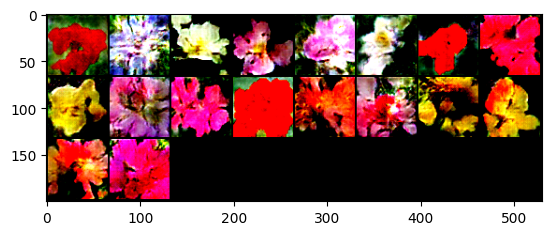

100%|██████████| 103/103 [00:09<00:00, 11.10it/s]


epoch: 32, lossD:0.4549042139093853, lossG:6.884011699158011,lossG_fake:3.7037806128992616, lossG_real:3.180231078157147 ,equality:0.5235495347421146


evaluate:108.2439193725586,kid_mean:0.0809050053358078, kid_std:0.047882080078125,kid_:(tensor(0.0809), tensor(0.0479))


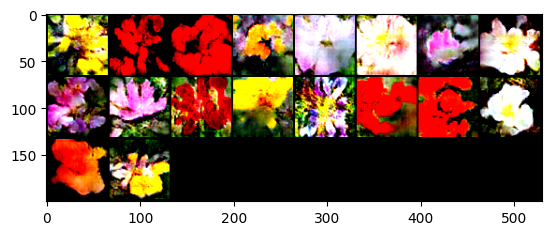

100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


epoch: 33, lossD:0.5089238880979783, lossG:7.020815400243963,lossG_fake:3.798750076479125, lossG_real:3.2220653260795817 ,equality:0.5766847503995431


evaluate:107.88636779785156,kid_mean:0.0745754987001419, kid_std:0.040101323276758194,kid_:(tensor(0.0746), tensor(0.0401))


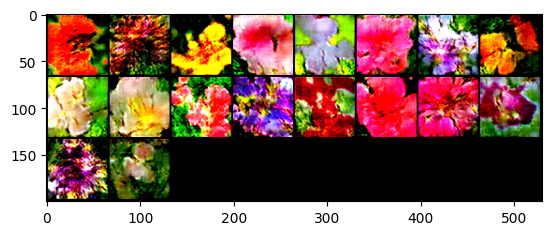

100%|██████████| 103/103 [00:09<00:00, 10.95it/s]


epoch: 34, lossD:0.42821177773322294, lossG:6.9797132871683365,lossG_fake:3.7696289830994836, lossG_real:3.210084301754109 ,equality:0.5595446813453746


evaluate:107.55316162109375,kid_mean:0.07376942783594131, kid_std:0.04135735705494881,kid_:(tensor(0.0738), tensor(0.0414))


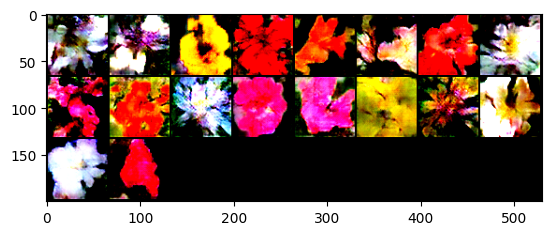

100%|██████████| 103/103 [00:09<00:00, 11.00it/s]


epoch: 35, lossD:0.47944324767415963, lossG:7.067020689399497,lossG_fake:3.809177821122327, lossG_real:3.2578428613329398 ,equality:0.5513349597893873


evaluate:108.27029418945312,kid_mean:0.07751896232366562, kid_std:0.0404377281665802,kid_:(tensor(0.0775), tensor(0.0404))


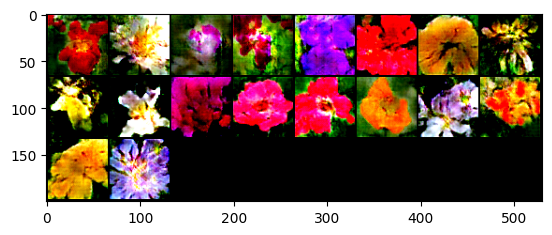

100%|██████████| 103/103 [00:09<00:00, 10.85it/s]


epoch: 36, lossD:0.4680658857003578, lossG:7.175758940502278,lossG_fake:3.87335250910046, lossG_real:3.302406434295247 ,equality:0.5709460748052133


evaluate:108.96102905273438,kid_mean:0.0705922394990921, kid_std:0.04452059045433998,kid_:(tensor(0.0706), tensor(0.0445))


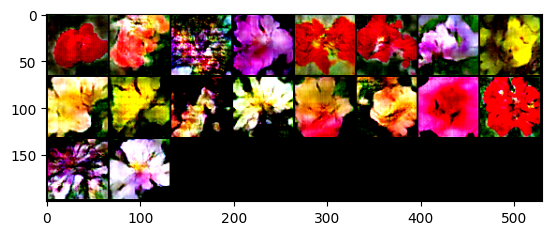

100%|██████████| 103/103 [00:09<00:00, 10.83it/s]


epoch: 37, lossD:0.4575541130475049, lossG:7.0330071310395175,lossG_fake:3.766429259939101, lossG_real:3.266577868785673 ,equality:0.4998513911534279


evaluate:109.63036346435547,kid_mean:0.07898789644241333, kid_std:0.04288569465279579,kid_:(tensor(0.0790), tensor(0.0429))


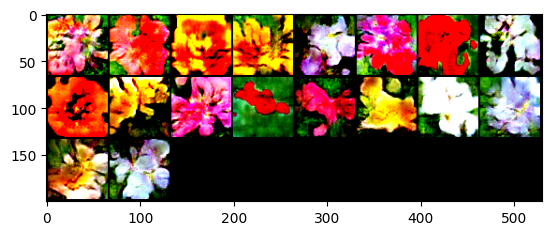

100%|██████████| 103/103 [00:09<00:00, 10.86it/s]


epoch: 38, lossD:0.43973930454948573, lossG:7.083666884783402,lossG_fake:3.780147268934157, lossG_real:3.3035196216361036 ,equality:0.4766276472980535


evaluate:109.03194427490234,kid_mean:0.07904566824436188, kid_std:0.040846142917871475,kid_:(tensor(0.0790), tensor(0.0408))


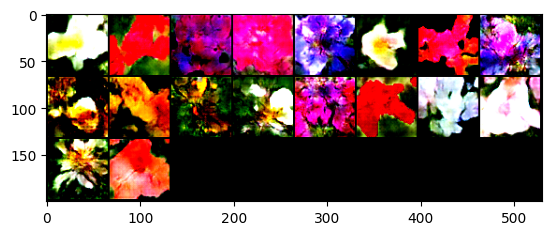

100%|██████████| 103/103 [00:09<00:00, 11.09it/s]


epoch: 39, lossD:0.3786481883630012, lossG:7.128120158482524,lossG_fake:3.7576580880915076, lossG_real:3.3704620819647335 ,equality:0.3871960061267741


evaluate:108.08717346191406,kid_mean:0.07552392780780792, kid_std:0.045277584344148636,kid_:(tensor(0.0755), tensor(0.0453))


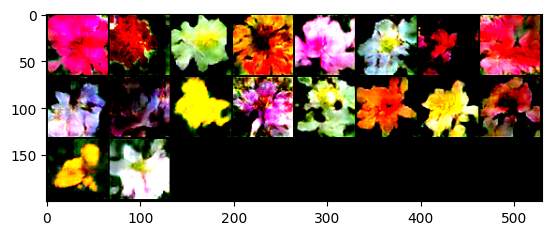

100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


epoch: 40, lossD:0.46048868078629945, lossG:7.32841540308832,lossG_fake:3.9486999789487967, lossG_real:3.379715413144491 ,equality:0.5689845658043056


evaluate:105.20340728759766,kid_mean:0.07013004273176193, kid_std:0.03937849774956703,kid_:(tensor(0.0701), tensor(0.0394))


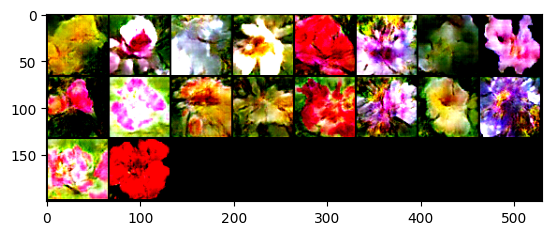

100%|██████████| 103/103 [00:09<00:00, 10.57it/s]


epoch: 41, lossD:0.3020041552779165, lossG:7.035142028216019,lossG_fake:3.7284817290537564, lossG_real:3.306660294532776 ,equality:0.42182143452098053


evaluate:106.18021392822266,kid_mean:0.07808554917573929, kid_std:0.040809471160173416,kid_:(tensor(0.0781), tensor(0.0408))


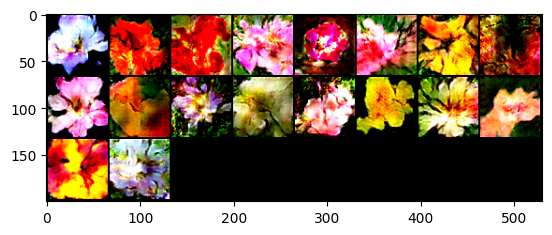

100%|██████████| 103/103 [00:09<00:00, 10.93it/s]


epoch: 42, lossD:0.36990684849544636, lossG:7.319459882754724,lossG_fake:3.897903791909079, lossG_real:3.421556073485069 ,equality:0.47634771842401014


evaluate:104.81402587890625,kid_mean:0.0684070885181427, kid_std:0.04298337548971176,kid_:(tensor(0.0684), tensor(0.0430))


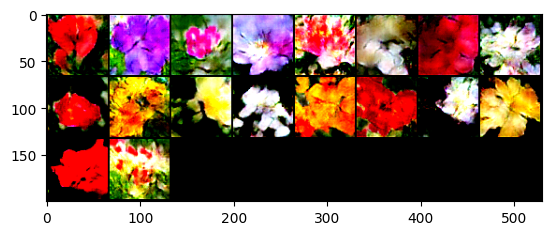

100%|██████████| 103/103 [00:09<00:00, 10.64it/s]


epoch: 43, lossD:0.4028156778585274, lossG:7.386149299954905,lossG_fake:3.870550059577794, lossG_real:3.51559924616397 ,equality:0.35495081341382395


evaluate:103.12577056884766,kid_mean:0.07717709243297577, kid_std:0.03926527500152588,kid_:(tensor(0.0772), tensor(0.0393))


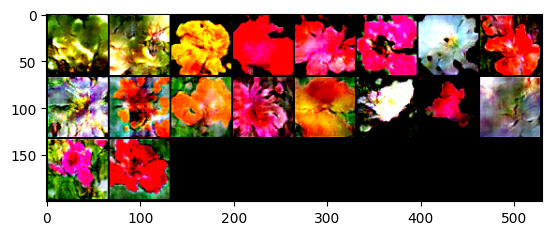

100%|██████████| 103/103 [00:09<00:00, 10.91it/s]


epoch: 44, lossD:0.37630552986582505, lossG:7.405038634550224,lossG_fake:3.902353584187702, lossG_real:3.5026850306872026 ,equality:0.39966855350049935


evaluate:104.43872833251953,kid_mean:0.0749490037560463, kid_std:0.040177084505558014,kid_:(tensor(0.0749), tensor(0.0402))


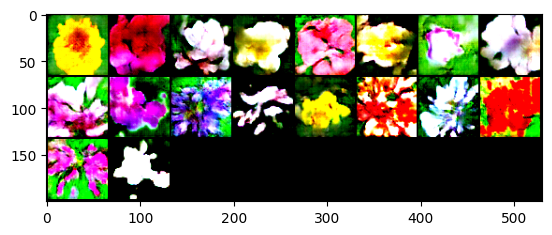

100%|██████████| 103/103 [00:09<00:00, 10.86it/s]


epoch: 45, lossD:0.34271192937655354, lossG:7.387415668339405,lossG_fake:3.8741881384432895, lossG_real:3.513227555358294 ,equality:0.36096058308499535


evaluate:104.20545196533203,kid_mean:0.07357586175203323, kid_std:0.03833499923348427,kid_:(tensor(0.0736), tensor(0.0383))


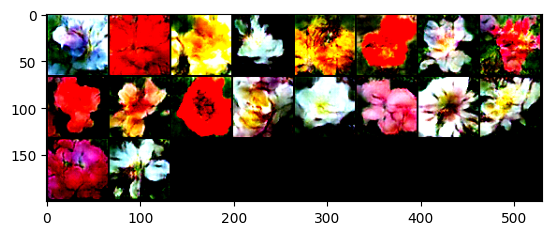

100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


epoch: 46, lossD:0.33401754722722526, lossG:7.507465621800098,lossG_fake:3.9398566935826276, lossG_real:3.5676089421059323 ,equality:0.3722477514766953


evaluate:103.19290161132812,kid_mean:0.07533590495586395, kid_std:0.04481346905231476,kid_:(tensor(0.0753), tensor(0.0448))


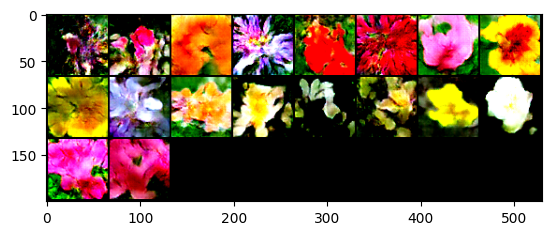

100%|██████████| 103/103 [00:09<00:00, 10.97it/s]


epoch: 47, lossD:0.3760657314464305, lossG:7.429653570489976,lossG_fake:3.9006415232292655, lossG_real:3.5290120550729696 ,equality:0.37162946815629594


evaluate:103.85743713378906,kid_mean:0.07185720652341843, kid_std:0.039944931864738464,kid_:(tensor(0.0719), tensor(0.0399))


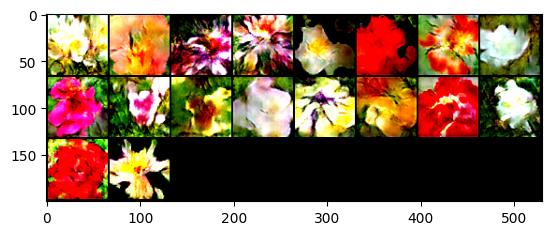

100%|██████████| 103/103 [00:09<00:00, 11.05it/s]


epoch: 48, lossD:0.31803566434429686, lossG:7.380820922481203,lossG_fake:3.8386885957810484, lossG_real:3.5421323197559245 ,equality:0.2965562760251239


evaluate:102.92660522460938,kid_mean:0.06182609871029854, kid_std:0.039856936782598495,kid_:(tensor(0.0618), tensor(0.0399))


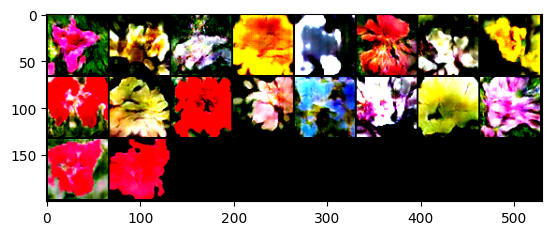

100%|██████████| 103/103 [00:09<00:00, 10.83it/s]


epoch: 49, lossD:0.3033967276004333, lossG:7.436931610107422,lossG_fake:3.9290813392805823, lossG_real:3.5078502627252375 ,equality:0.42123107655534486


evaluate:102.38504028320312,kid_mean:0.08447927236557007, kid_std:0.04398736730217934,kid_:(tensor(0.0845), tensor(0.0440))


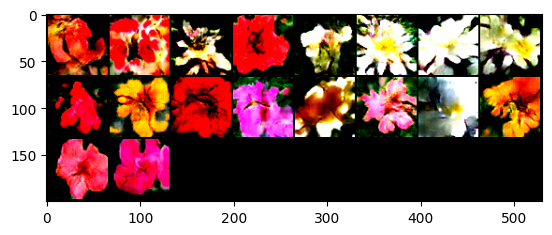

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

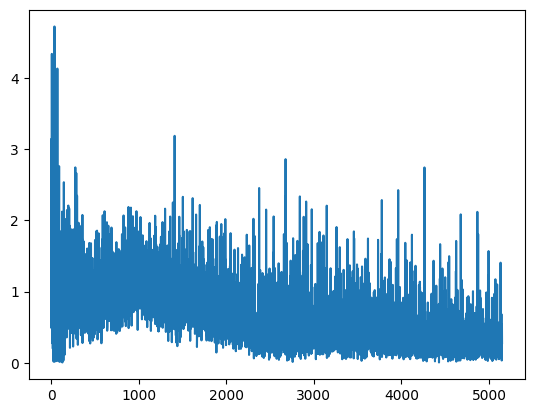

In [45]:
plt.plot(raw_lossesD)

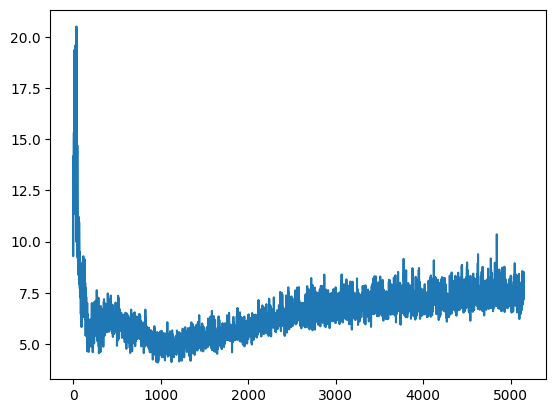

In [46]:
plt.plot(raw_lossesG)

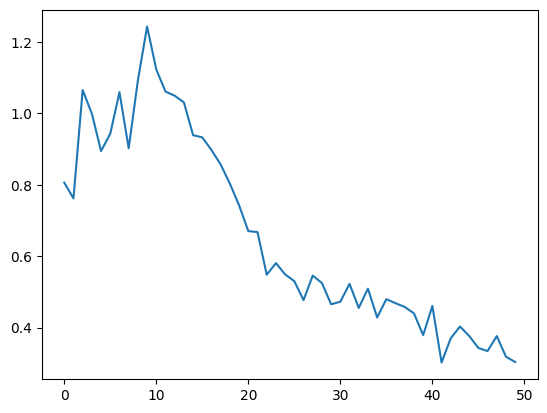

In [47]:
plt.plot(lossesD)

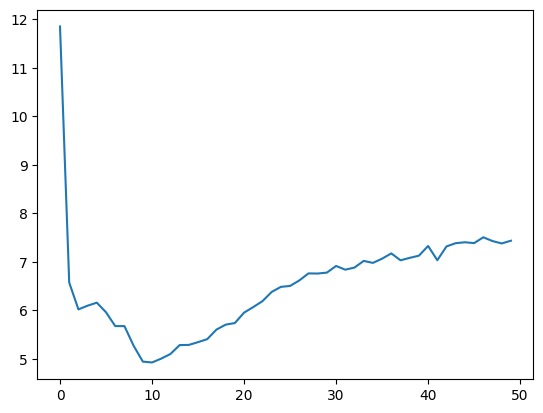

In [48]:
plt.plot(lossesG)

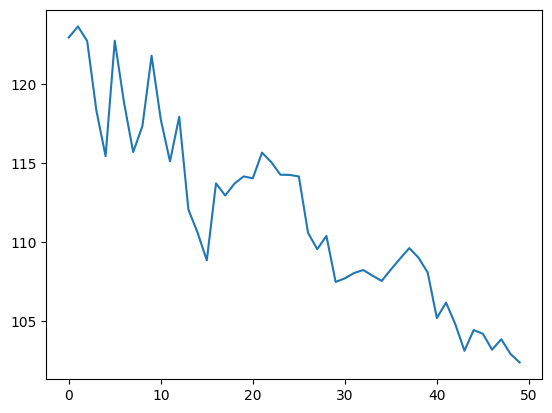

In [49]:
plt.plot(fid_)

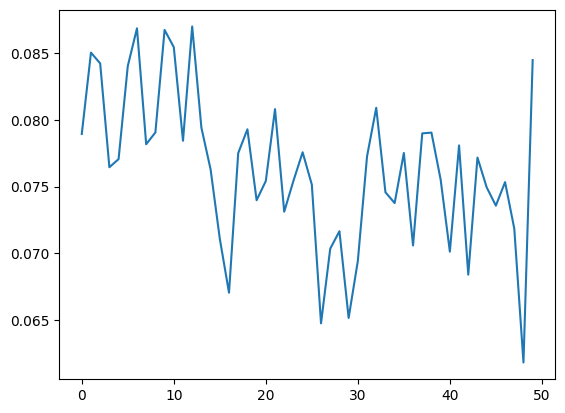

In [50]:
plt.plot(kid_mean_)

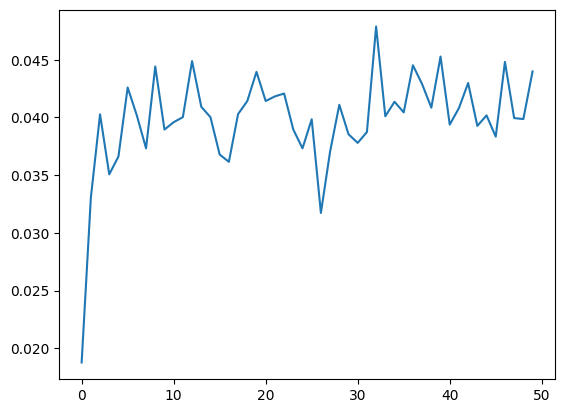

In [51]:
plt.plot(kid_std_)

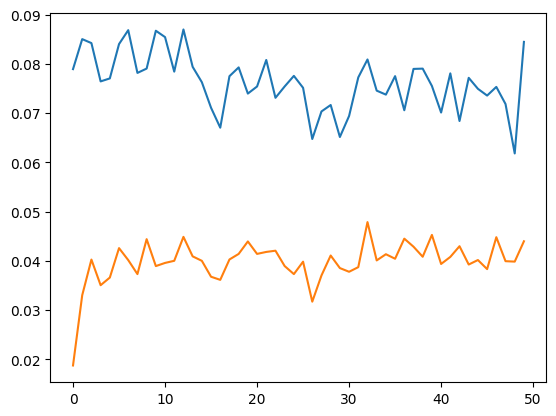

In [52]:
plt.plot(kid_score)

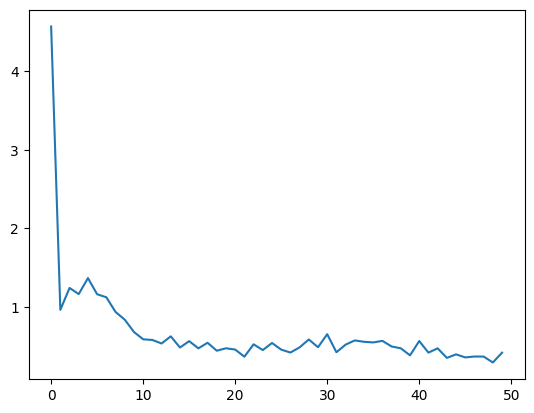

In [53]:
plt.plot(d_equality)

In [54]:
import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00
fid  tensor(101.8669)
kid  (tensor(0.0746), tensor(0.0447))
PSNR tensor(79.6193)
SSIM値: 0.9988757879711873
